In [6]:
from node2vec2rank.evaluation import read_gmt, normalized_discounted_cumulative_gain, parallel_empirical_p_ndcg
import copy
from node2vec2rank.utils import network_transform
import numpy as np
import pandas as pd
import random
import os
import sys
import multiprocessing
import spectral_embedding as se
import matplotlib.pyplot as plt
import matplotlib as mpl
import csrgraph as cg
import warnings
warnings.filterwarnings('ignore')

n_cores = multiprocessing.cpu_count()


sys.path.insert(1, os.path.realpath(os.path.pardir))


# import statsmodels.stats.multitest as mtc

In [7]:
# #gene regulatory network filenames to load
# # grn_filenames = ('panda_PAAD_gtex.tsv', 'panda_PANC_tcga.tsv')
# # grn_filenames = ('panda_PANC_GTEX_big.tsv', 'panda_PANC_TCGA_big.tsv')

# grn_filenames = ('wgcna_PANC_GTEX.csv', 'wgcna_PAAD_TCGA.csv')
# # grn_filenames = ('gtex_breast_adj.tsv', 'gtex_colon_adj.tsv')
# # grn_filenames = ('cancer_breast_otter_network.csv', 'cancer_liver_otter_network.csv')
# grn_filenames = ('lung_panda_male_cpu_adj.tsv', 'lung_panda_female_cpu_adj.tsv')
# grn_filenames = ('Normal_df_panda.tsv', 'Core_df_panda.tsv')
# grn_filenames = ('epithelial_panda.tsv', 'cancer_panda.tsv')
grn_filenames = ('mean_male_dragon_reg.csv', 'mean_female_dragon_reg.csv')
# grn_filenames = ('giraffe_male_luad.csv', 'giraffe_female_luad.csv')
# grn_filenames = ('giraffe_gtex.csv', 'giraffe_tcga.csv')
# grn_filenames = ('panda_tcga_paad_male.txt', 'panda_tcga_paad_female.txt')
# grn_filenames = ('panda/panda_tcga_xprs_luad_logcpm_1_01_nodupl_purCPE05.tsv', 'panda/panda_gtex_xprs_lung_logcpm_1_01_nodupl.tsv')
# grn_filenames = ('panda/panda_tcga_xprs_luad_logcpm_1_01_nodupl_purCPE05.tsv', 'panda/panda_gtex_xprs_lung_logcpm_1_01_nodupl.tsv')
# grn_filenames = ('panda/panda_gtex_lung_transnodot.tsv', 'panda/panda_gtex_lung_batchcor_transnodot.tsv')
# grn_filenames = ('panda/panda_gtex_xprs_breast_logcpm_1_01_nodupl_ONLYFEM.tsv', 'panda/panda_tcga_xprs_brca_logcpm_1_01_nodupl_purCPE075.tsv')
# grn_filenames = ('wgcna/wgcna_p6_gtex_xprs_lung_logcpm_1_01_nodupl.tsv', 'wgcna/wgcna_p6_tcga_xprs_luad_logcpm_1_01_nodupl_purCPE05.tsv')
# grn_filenames = ("TCGA_lung_panda_male_adj.tsv","TCGA_lung_panda_female_adj.tsv")
# grn_filenames = ("panda/enakshi/TCGA_lung_panda_male.h5","panda/enakshi/TCGA_lung_panda_female.h5")
# grn_filenames = ("wgcna/viola/wgcna_recount3_tcga_kirc_purity03_normlogtpm_mintpm1_fracsamples01_tissueall_batchnull_adjnull_MALE-tumor_power10.h5",
#                  "wgcna/viola/wgcna_recount3_tcga_kirc_purity03_normlogtpm_mintpm1_fracsamples01_tissueall_batchnull_adjnull_FEMALE-tumor_power10.h5")

# grn_filenames = ("wgcna/viola/wgcna_recount3_tcga_luad_purity03_normlogtpm_mintpm1_fracsamples01_tissueall_batchnull_adjnull_MALE-tumor_power10.h5",
#                  "wgcna/viola/wgcna_recount3_tcga_luad_purity03_normlogtpm_mintpm1_fracsamples01_tissueall_batchnull_adjnull_FEMALE-tumor_power10.h5")


exp = 'real'


# do the data have index and header??
# if it is .csv, most likely the sep = ","
#  if it is .tsv, most likely the sep = "\t"
index_col = 0
header = 0
sep = ','


# load the gene regulatory networks into PANDAS dataframes and then to numpy and then to a list
grns = []
for grn_filename in grn_filenames:
    if 'h5' not in grn_filename:
        grn_pd = pd.read_csv('../networks/'+grn_filename,
                             index_col=index_col, header=header, sep=sep)
    else:
        grn_pd = pd.read_hdf('../networks/'+grn_filename, 'df')

    grn_pd = grn_pd.sort_index(ascending=True)
    grns.append(grn_pd)

In [8]:
# grns[0].to_hdf('../networks/wgcna/viola/wgcna_recount3_tcga_luad_purity03_normlogtpm_mintpm1_fracsamples01_tissueall_batchnull_adjnull_MALE-tumor_power10.h5', key='df')
# grns[1].to_hdf('../networks/wgcna/viola/wgcna_recount3_tcga_luad_purity03_normlogtpm_mintpm1_fracsamples01_tissueall_batchnull_adjnull_FEMALE-tumor_power10.h5', key='df')

In [9]:
# transform/prepare

row_genes = grns[0].index.to_numpy()
col_genes = grns[0].columns.to_numpy()

# pd.DataFrame([x[0:15] for x in col_genes]).to_csv('../results/current_background.csv',header=False, index=None)


total_genes = np.append(row_genes, col_genes)
total_genes = np.unique(total_genes)

num_rows = np.size(row_genes)
num_cols = np.size(col_genes)
num_total = np.size(total_genes)

print(f"There are {num_rows} row genes, {num_cols} column genes, and {num_total} unique in first (anchor) graph")

node_dict = dict(zip(np.arange(len(total_genes)), total_genes))

# network transformation

# parameteres for network transformation
# make the network binary
binarize_network = False

# only keeps the top %
quantile_to_keep = 100

# transform the networks
grns_transformed = []
for grn in grns:
    grns_transformed.append(network_transform(grn.to_numpy(),
                                              binarize=binarize_network,
                                              threshold=0,
                                              absolute=True,
                                              quantile_to_keep=quantile_to_keep))


# do this for already symmetric matrices
np.fill_diagonal(grns_transformed[0], 0)
np.fill_diagonal(grns_transformed[1], 0)

There are 1300 row genes, 1300 column genes, and 1300 unique in first (anchor) graph
Size before: [1300, 1300] size after: (1300, 1300)
Size before: [1300, 1300] size after: (1300, 1300)


In [21]:
# read the filenames for evaluation and mapping

gencode_fn = '../scripts/gen_v26_mapping.csv'
kegg_pathway_fn = '../scripts/c2.cp.kegg.v7.5.1.symbols.gmt'
x_escapee_fn = '../scripts/X_escapees.csv'

In [13]:
# get DeDi

# filter genes and tfs from rows and columns respectively

net_one_adj = grns[0].copy()
net_two_adj = grns[1].copy()

# # map ensembl to gene name
# gencode = pd.read_csv(gencode_fn, index_col = 0)
# # ensembl to symbol map
# ens2symbol = {i['gene_id'].split('.')[0]:i['gene_name'] for k,i in gencode.iterrows()}

net_one_adj_tar = net_one_adj.sum(axis=0).to_numpy()
net_two_adj_tar = net_two_adj.sum(axis=0).to_numpy()
DeDi_genes_name = net_one_adj.columns.to_list()
# DeDi_genes_id = [x[0:15] for x in DeDi_genes_id]
# DeDi_genes_name = [ens2symbol[x] for x in DeDi_genes_id]

DeDi = net_one_adj_tar - net_two_adj_tar
absDeDi = np.abs(DeDi)

DeDi_data = {"genes": DeDi_genes_name, "DeDi": DeDi, "absDeDi": absDeDi}

DeDi_data = pd.DataFrame(DeDi_data, index=DeDi_genes_name)
DeDi_data.sort_values(by='absDeDi', ascending=False, inplace=True)

In [19]:
from node2vec2rank.model import Model2Rank
from node2vec2rank.multimodel import MultiModel2Rank

import json
from scipy.sparse import csc_matrix
import shutil

# Opening JSON file

# returns JSON object as
# a dictionary
# read the config file and create output file it doesn't exist
config = json.load(open('../configs/config_DRAGON.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

os.makedirs(config["main_save_dir"], exist_ok=True)

graphs = []
# print(data['method'] )
if config['method'] == 'UASE':
    graphs.append(csc_matrix(grns_transformed[0]))
    graphs.append(csc_matrix(grns_transformed[1]))
else:
    graphs.append(cg.csrgraph(grns_transformed[0]))
    graphs.append(cg.csrgraph(grns_transformed[1]))

# model = Model2Rank(node_dict=node_dict, config=data, graphs=graphs)
# rankings = model.walk_fit_rank()

# check if there are multiple values for any given parameter
multi_params = [key for key in config.keys() if isinstance(
    config[key], list) and len(config[key]) > 1]
if not multi_params:
    print("Model2Rank")
    model = Model2Rank(graphs=graphs, config=config, node_dict=node_dict)
    rankings = model.walk_fit_rank()
else:
    print('MultiModel2Rank')
    model = MultiModel2Rank(graphs=graphs, config=config, node_dict=node_dict)
    rankings = model.walk_fit_rank()


rankings.index = [x[0:15] for x in total_genes]

MultiModel2Rank
Running Node2Vec2Rank with the following parameter combinations:
Timestamp:03_29_2023_23_31_10
################################################################
Combination 1
absolute             	binarize             	bipartite            	directed             	embed_dim            	epochs               	is_edge_list         	max_iter_first       	max_iter_second      	multi_mode           	n_components_manifold	negative             	neighbor_weight      	quantile_to_keep     	repetitions          	return_weight        	run_random_walks     	seed                 	symmetrize           	visualize            	walklen              	window               
0                    	0                    	0                    	0                    	4                    	30                   	0                    	5                    	5                    	1                    	2                    	5                    	1                    	100                  	5                 

In [20]:
# works for multimodel and simple model

n2v2r_rankings = rankings.filter(like="dist", axis=1)
# n2v2r_rankings = n2v2r_rankings.mean(axis=1)
# n2v2r_rankings.sort_values(ascending = False, inplace=True)
# n2v2r_ranked_nodes = n2v2r_avg_distances.index.to_list()
# n2v2r_ranked_nodes

# n2v2r_data_dict = {"genes":n2v2r_ranked_nodes, "score" :n2v2r_avg_distances.values}

n2v2r_data = n2v2r_rankings

In [40]:
import gseapy
from collections import defaultdict


consensus_dict = defaultdict(int)
for (columnName, columnData) in n2v2r_data.items():
    ranking_pd = pd.DataFrame(columnData, index=n2v2r_data.index.to_list())

    pre_res = gseapy.prerank(rnk=ranking_pd,  # or rnk = rnk,
                             gene_sets=kegg_pathway_fn,
                             threads=96,
                             min_size=5,
                             max_size=10,
                             permutation_num=1000,  # reduce number to speed up testing
                             outdir=None,  # don't write to disk
                             seed=6,
                             verbose=True,  # see what's going on behind the scenes
                             weighted_score_type=0
                             )

    filtered_prerank = pre_res.res2d.loc[(
        pre_res.res2d['FDR q-val'] <= 0.25) & (pre_res.res2d["NES"] > 0)]['Term']

    for pathway in filtered_prerank:
        consensus_dict[pathway] += 1

consensus_pd = pd.DataFrame(consensus_dict.items(),
                            columns=['pathway', 'freq'])
consensus_pd['freq'] = consensus_pd['freq']/len(n2v2r_data.columns)

2023-03-30 00:05:28,651 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-03-30 00:05:28,652 [INFO] Parsing data files for GSEA.............................
2023-03-30 00:05:28,661 [INFO] 0158 gene_sets have been filtered out when max_size=10 and min_size=5
2023-03-30 00:05:28,661 [INFO] 0028 gene_sets used for further statistical testing.....
2023-03-30 00:05:28,662 [INFO] Start to run GSEA...Might take a while..................
2023-03-30 00:05:28,798 [INFO] Congratulations. GSEApy runs successfully................

2023-03-30 00:05:28,803 [INFO] Parsing data files for GSEA.............................
2023-03-30 00:05:28,808 [INFO] 0158 gene_sets have been filtered out when max_size=10 and min_size=5
2023-03-30 00:05:28,808 [INFO] 0028 gene_sets used for further statistical testing.....
2023-03-30 00:05:28,809 [INFO] Start to run GSEA...Might take a while..................
2023-

In [32]:
pre_res.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,KEGG_CHEMOKINE_SIGNALING_PATHWAY,0.697823,2.229388,0.0,0.016283,0.011,6/7,16.31%,STAT1;FOXO3;STAT2;NFKB1;STAT3;STAT5B
1,prerank,KEGG_BASAL_CELL_CARCINOMA,-0.513932,-1.741931,0.02834,0.152031,0.193,8/8,49.00%,TP53;GLI3;GLI1;TCF7L2;TCF7L1;LEF1;TCF7;GLI2
2,prerank,KEGG_BASAL_TRANSCRIPTION_FACTORS,0.545174,1.534789,0.057582,0.638719,0.469,5/5,45.69%,TBPL1;GTF2I;TBP;GTF2IRD1;GTF2B
3,prerank,KEGG_JAK_STAT_SIGNALING_PATHWAY,0.395215,1.435187,0.09127,0.675971,0.599,5/9,16.31%,STAT1;STAT2;STAT6;STAT3;STAT5B
4,prerank,KEGG_RENAL_CELL_CARCINOMA,0.48171,1.42443,0.119835,0.532882,0.612,5/6,35.38%,JUN;ARNT;ETS1;EPAS1;HIF1A
5,prerank,KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,0.49112,1.368875,0.108216,0.533474,0.682,3/5,11.08%,CREB1;NFYC;NFYB
6,prerank,KEGG_MELANOGENESIS,-0.306202,-1.173429,0.264646,0.889886,0.896,6/10,29.69%,CREB3L4;TCF7L2;MITF;TCF7L1;CREB3L1;LEF1
7,prerank,KEGG_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY,0.334365,1.157403,0.29703,0.958448,0.91,4/8,16.77%,STAT1;JUN;NFKB1;IRF7
8,prerank,KEGG_ADHERENS_JUNCTION,-0.337848,-1.154768,0.264151,0.637009,0.91,7/8,54.00%,TCF7L2;TCF7L1;LEF1;SNAI1;TCF7;SMAD4;SNAI2
9,prerank,KEGG_LEISHMANIA_INFECTION,0.368624,1.122577,0.293307,0.906746,0.932,3/6,13.31%,STAT1;JUN;NFKB1


In [31]:
filtered_prerank = pre_res.res2d.loc[(
    pre_res.res2d['FDR q-val'] <= 0.25) & (pre_res.res2d["NES"] > 0)]['Term']

In [8]:
# ## checking per combo wazzup
# check_combos = True


# # map ensembl to gene name
# gencode = pd.read_csv(gencode_fn, index_col = 0)


# # ensembl to symbol map
# ens2symbol = {i['gene_id'].split('.')[0]:i['gene_name'] for k,i in gencode.iterrows()}

# kegg_pathways = read_gmt(kegg_pathway_fn, False)


# relevant_genes = set(gencode.loc[gencode['seqid'] == 'chrY' ,'gene_name'])
# # relevant_genes = set(pathways['KEGG_PANCREATIC_CANCER'])

# if check_combos:
#     ##
#     ranking_distances_per_combo = rankings.filter(like="dist", axis=1)
#     n2v2r_avg_distances = ranking_distances_per_combo.mean(axis=1)
#     n2v2r_ranked_nodes = n2v2r_avg_distances.sort_values(ascending = False, inplace=False).index.to_list()


#     names_of_combos = []
#     score_of_combos = []
#     for (columnName, columnData) in ranking_distances_per_combo.items():
#         n2v2r_combo_ranking = columnData.sort_values(ascending = False, inplace=False).index.to_list()

#         top_k = 5000
#         num_perms = 2000
#         # map ensembl to gene name

#         ranked_nodes = n2v2r_combo_ranking.copy()
#         ##remove stupid dot if there
#         ranked_nodes = [x[0:15] for x in ranked_nodes]

#         ranked_nodes_symbols = [ens2symbol[x] if "ENSG" in x else x for x in ranked_nodes]


#         relevance_vector = [1 if x in relevant_genes else 0  for x in ranked_nodes_symbols ]

#         data = {"ranked_nodes":ranked_nodes_symbols, "relevant":relevance_vector, "dist." : n2v2r_avg_distances}
#         data = pd.DataFrame(data)

#         relevance_score = normalized_discounted_cumulative_gain(relevance_vector)

#         ranked_nodes_symbols_permutations = [random.sample(ranked_nodes_symbols,len(ranked_nodes_symbols)) for _ in range(num_perms)]

#         pval_parallel= parallel_empirical_p_ndcg(relevance_score, ranked_nodes_symbols_permutations, relevant_genes)

#         print(f"Score {relevance_score} with pval {pval_parallel}")

#         if 'euclidean' in columnName:
#             columnName=columnName.replace("euclidean",'1')
#         else:
#             columnName= columnName.replace("cosine",'0')


#         names_of_combos.append(columnName)
#         score_of_combos.append(relevance_score)


#     def return_numbers(sentence):
#         return [int(i) for i in sentence.split(" ") if i.isdigit()]


#     list_of_parameter_values = list(map(return_numbers, names_of_combos))

#     data_of_parameters = pd.DataFrame(list_of_parameter_values, columns=['dim',"#walks","len","window",".dist"])
#     data_of_parameters["total_ndcg"] = score_of_combos

In [9]:
# load = False
# if check_combos and not load:
#     data_of_parameters = pd.DataFrame(list_of_parameter_values, columns=['dim',"#walks","len","window","dist."])
#     data_of_parameters["total_ndcg"] = score_of_combos
#     data_of_parameters.to_csv('../results/wgcnaPancVSPaad', index=False)

# elif check_combos and load:
#     data_of_parameters = pd.read_csv('../results/maleVSfemaleParameterTestingAll',sep="\t")

# data_of_parameters = pd.read_csv('../results/maleVSfemaleParameterTestingAll',sep="\t")
# data_of_parameters.groupby(['len',"#walks"])['total_ndcg'].plot(legend=True)

In [10]:
# #### try to aggregate ranks according to rank aggregation methods
# import rankaggregation as ra

# # top_k=5000
# #create one ranking per combo
# n2v2r_distances_per_combo = rankings.filter(like="dist", axis=1)
# index = rankings.index.to_list()

# ranked_lists = []
# for (columnName, columnData) in n2v2r_distances_per_combo.items():
#     # if ("8" not in columnName) and  ("16" not in columnName):
#     #     continue
#     # print(columnName)

#     temp_df = pd.DataFrame(columnData.values, columns=['col'], index = index)
#     temp_df.sort_values(by='col', ascending=False, inplace=True)
#     ranked_lists.append(temp_df.index.to_list())

# agg = ra.RankAggregator()
# borda_ranking = agg.borda(ranked_lists)

# borda_ranking = [x[0] for x in borda_ranking]

In [11]:
save_for_gsea = True
sex_and_gender = True

if save_for_gsea:
    n2v2r_data_sorted = n2v2r_data.sort_values(ascending=False)

    # map ensembl to gene name
    gencode = pd.read_csv(gencode_fn, index_col=0)
    # ensembl to symbol map
    ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
                  for k, i in gencode.iterrows()}

    nodes_id = n2v2r_data_sorted.index.to_list()
    nodes_id = [x[0:15] for x in nodes_id]
    nodes_symbol = [ens2symbol[x] for x in nodes_id]
    n2v2r_data_sorted.index = nodes_symbol

    if sex_and_gender:
        Y_gene_names = set(
            gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
        n2v2r_data_sorted = n2v2r_data_sorted[~n2v2r_data_sorted.index.isin(
            Y_gene_names)]

    n2v2r_data_sorted.to_csv(
        "../results_gsea/LUADmalevsFemale_n2v2r_res.rnk", header=False, sep="\t")

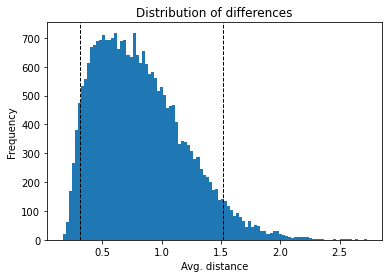

In [12]:
import matplotlib.pyplot as plt

dists = n2v2r_data.values
plt.hist(dists, bins=100)
plt.title('Distribution of differences')
plt.xlabel("Avg. distance")
plt.ylabel("Frequency")
top_cutoff = np.percentile(dists, 95)
# top_cutoff = 1.2

plt.axvline(top_cutoff, color='k', linestyle='dashed', linewidth=1)
ind_keep = np.where(dists >= top_cutoff)[0]
top_interesting_ranked_genes = n2v2r_data[ind_keep].index.to_list()

bottom_cutoff = np.percentile(dists, 5)
# bottom_cutoff = 0.05
plt.axvline(bottom_cutoff, color='k', linestyle='dashed', linewidth=1)
ind_keep = np.where(dists <= bottom_cutoff)[0]
bottom_top_interesting_ranked_genes = n2v2r_data[ind_keep].index.to_list()

save_res = True
if save_res:
    # rank_fl = "AAc"+grn_filenames[0] + "VS" + grn_filenames[1] + "_rw-" + str(return_weight) + "_nw-" +str(neighbor_weight) +"_l-" + str(walklen) + \
    #     "_n-" + str(epochs) + "_w-" + str(window) + "_d-" + str(embed_dim) + "_ef-" + str(epochs_first) + "_es-" + str(epochs_second) + ".rnk"
    pd.DataFrame(top_interesting_ranked_genes).to_csv(
        '../results/current_top_n2v2r.csv', index=False, header=None, sep=",")
    pd.DataFrame(bottom_top_interesting_ranked_genes).to_csv(
        '../results/current_bottom_n2v2r.csv', index=False, header=None, sep=",")

    # interesting_ranked_genes.to_csv('../results/someres.csv' , index = False, header=None, sep = ",")
    # rankings.to_csv('../results/enakshiSeperateTcgaMalevsFemaleW2V32ForGroupPresi.csv' , index = False, header=True, sep = ",")

In [13]:
# pd.DataFrame(borda_ranking).to_csv("../results/current_borda.csv", index=False, header=None)

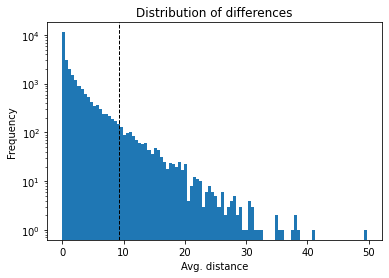

In [14]:
import matplotlib.pyplot as plt


# get DeDi


top_cutoff_DeDi = DeDi_data.absDeDi.quantile(0.95)
# top_cutoff = 290


top_interesting_ranked_genes_dedi = DeDi_data.loc[DeDi_data["absDeDi"]
                                                  >= top_cutoff_DeDi]['genes'].to_numpy()

dists = DeDi_data.absDeDi
plt.hist(dists, bins=100, log=True)
plt.title('Distribution of differences')
plt.xlabel("Avg. distance")
plt.ylabel("Frequency")
# top_cutoff = 0.4

plt.axvline(top_cutoff_DeDi, color='k', linestyle='dashed', linewidth=1)
ind_keep = np.where(dists >= top_cutoff)[0]

pd.DataFrame(top_interesting_ranked_genes_dedi).to_csv(
    '../results/current_top_DeDi.csv', index=False, header=None, sep=",")

# # map ensembl to gene name
# gencode = pd.read_csv(gencode_fn, index_col = 0)
# # ensembl to symbol map
# ens2symbol = {i['gene_id'].split('.')[0]:i['gene_name'] for k,i in gencode.iterrows()}

# # top_interesting_ranked_genes = [ens2symbol[x] if "ENSG" in x else x for x in top_interesting_ranked_genes]

# bottom_cutoff = np.percentile(n2v2r_avg_distances, 5)
# # bottom_cutoff = 0.4
# plt.axvline(bottom_cutoff, color='k', linestyle='dashed', linewidth=1)
# ind_keep = np.where(dists<=bottom_cutoff)[0]
# bottom_top_interesting_ranked_genes = n2v2r_avg_distances[ind_keep].index.to_list()
# bottom_top_interesting_ranked_genes = [x[0:15] for x in bottom_top_interesting_ranked_genes]

In [15]:
save_for_gsea = True
sex_and_gender = True

if save_for_gsea:

    if sex_and_gender:
        Y_gene_names = set(
            gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
        DeDi_data = DeDi_data[~DeDi_data.genes.isin(Y_gene_names)]

    DeDi_data[['genes', 'absDeDi']].to_csv(
        "../results_gsea/LUADmalevsFemale_AbsDeDi_res.rnk", header=False, index=None, sep="\t")
    DeDi_data[['genes', 'DeDi']].to_csv(
        "../results_gsea/LUADmalevsFemale_DeDi_res.rnk", header=False, index=None, sep="\t")

In [21]:
# check ranking for some set of genes for n2v2r

# map ensembl to gene name
gencode = pd.read_csv(gencode_fn, index_col=0)


# ensembl to symbol map
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}


kegg_pathways = read_gmt(kegg_pathway_fn, False)

escapee_genes = pd.read_csv(x_escapee_fn, sep=",", header=None).iloc[0, :]


relevant_genes = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
# relevant_genes = set(kegg_pathways['KEGG_PANCREATIC_CANCER'])
relevant_genes = set(escapee_genes).union(
    gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])

num_perms = 2000

ranked_nodes = n2v2r_ranked_nodes.copy()
# remove stupid dot if there
ranked_nodes = [x[0:15] for x in ranked_nodes]

ranked_nodes_symbols_n2v2r = [ens2symbol[x]
                              if "ENSG" in x else x for x in ranked_nodes]

relevance_vector = [
    1 if x in relevant_genes else 0 for x in ranked_nodes_symbols_n2v2r]

relevance_data = {"ranked_nodes": ranked_nodes_symbols_n2v2r,
                  "rel": relevance_vector}
relevance_data_df = pd.DataFrame(relevance_data)

relevance_score = normalized_discounted_cumulative_gain(relevance_vector)

ranked_nodes_symbols_permutations = [random.sample(ranked_nodes_symbols_n2v2r, len(
    ranked_nodes_symbols_n2v2r)) for _ in range(num_perms)]

# if top_k < len(ranked_nodes_symbols):
#     ranked_nodes_symbols = ranked_nodes_symbols[:top_k]
#     ranked_nodes_symbols_permutations = [perm[:top_k] for perm in ranked_nodes_symbols_permutations]

pval_parallel = parallel_empirical_p_ndcg(
    relevance_score, ranked_nodes_symbols_permutations, relevant_genes)

print(f"Relevance score {relevance_score} with pval {pval_parallel}")

Relevance score 0.5630684096328213 with pval 0.039


In [22]:
# check ranking for some set of genes for DeDi

# map ensembl to gene name
gencode = pd.read_csv(gencode_fn, index_col=0)


# ensembl to symbol map
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}

kegg_pathways = read_gmt(kegg_pathway_fn, False)

escapee_genes = pd.read_csv(x_escapee_fn, sep=",", header=None).iloc[0, :]


relevant_genes = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
# relevant_genes = set(kegg_pathways['KEGG_PANCREATIC_CANCER'])
relevant_genes = set(escapee_genes).union(
    gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])


num_perms = 2000


# DeDi doesnt care about preprocessing, so reading the data from the df
# if wgcna, then go straight to summing rows or columns
# if panda, get the TFs on the rows and genes on columns first

net_one_adj = grns[0].copy()
net_two_adj = grns[1].copy()


net_one_adj_tar = net_one_adj.sum(axis=0).to_numpy()
net_two_adj_tar = net_two_adj.sum(axis=0).to_numpy()
DeDi_genes_id = net_one_adj.columns.to_list()
DeDi_genes_id = [x[0:15] for x in DeDi_genes_id]


DeDi = net_one_adj_tar - net_two_adj_tar
DeDi_genes_name = [ens2symbol[x] for x in DeDi_genes_id]

DeDi_data = pd.DataFrame(np.abs(DeDi), columns=[
                         'absDeDi'], index=DeDi_genes_name)
DeDi_data.sort_values(by='absDeDi', ascending=False, inplace=True)

ranked_nodes_symbols_DeDi = DeDi_data.index.to_list()

relevance_vector = [
    1 if x in relevant_genes else 0 for x in ranked_nodes_symbols_DeDi]


relevance_score = normalized_discounted_cumulative_gain(relevance_vector)

ranked_nodes_symbols_permutations = [random.sample(ranked_nodes_symbols_DeDi, len(
    ranked_nodes_symbols_DeDi)) for _ in range(num_perms)]

pval_parallel = parallel_empirical_p_ndcg(
    relevance_score, ranked_nodes_symbols_permutations, relevant_genes)

print(f"Relevance score {relevance_score} with pval {pval_parallel}")

Relevance score 0.546854257488383 with pval 0.9605


In [23]:
# ndcg tests for n2v2r and kegg

# all, tfs , genes, wgcna
sex_and_gender = True
top_k = 5000
num_perms = 2000

# map ensembl to gene name
gencode = pd.read_csv(gencode_fn, index_col=0)

# ensembl to symbol map
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}

kegg_pathways = read_gmt(kegg_pathway_fn, False)

ranked_nodes = n2v2r_ranked_nodes.copy()
# remove stupid dot if there
ranked_nodes = [x[0:15] for x in ranked_nodes]

# from ids to names and exluding maybe TFs or Genes for Panda networks

ranked_nodes_symbols = [ens2symbol[x] for x in ranked_nodes]

if sex_and_gender:
    Y_gene_names = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
    ranked_nodes_symbols = [
        x for x in ranked_nodes_symbols if x not in Y_gene_names]

# remove duplicates in case a tf and gene
# have the same name, keeping the first in order
ranked_nodes_symbols = list(dict.fromkeys(ranked_nodes_symbols))
ranked_nodes_symbols_permutations = [random.sample(
    ranked_nodes_symbols, len(ranked_nodes_symbols)) for _ in range(num_perms)]

if (top_k is not None) and (top_k < len(ranked_nodes_symbols)):
    ranked_nodes_symbols = ranked_nodes_symbols[:top_k]
    ranked_nodes_symbols_permutations = [perm[:top_k]
                                         for perm in ranked_nodes_symbols_permutations]

n2v2r_ndcg_pathway_stats = []
for pathway in kegg_pathways:
    print(f'Checking pathway {pathway}')
    genes_in_pathway = kegg_pathways[pathway]
    relevance_vector = [
        1 if x in genes_in_pathway else 0 for x in ranked_nodes_symbols]

    if sum(relevance_vector) == 0:
        continue

    percentage_in_pathway = round(
        float(sum(relevance_vector)/len(genes_in_pathway)), 2)*100
    score = round(normalized_discounted_cumulative_gain(relevance_vector), 3)

    ideal_numerator = (2**np.ones(sum(relevance_vector))-1)
    ideal_numerator = np.pad(ideal_numerator, (0, len(
        relevance_vector)-sum(relevance_vector)), mode='constant')
    denominator = np.log2(np.arange(len(relevance_vector)) + 2)

    pval_parallel = parallel_empirical_p_ndcg(score, ranked_nodes_symbols_permutations, genes_in_pathway,
                                              denominator=denominator, ideal_numerator=ideal_numerator)
    n2v2r_ndcg_pathway_stats.append(
        [pathway, len(genes_in_pathway), percentage_in_pathway, score, pval_parallel])

Checking pathway KEGG_N_GLYCAN_BIOSYNTHESIS
Checking pathway KEGG_OTHER_GLYCAN_DEGRADATION
Checking pathway KEGG_O_GLYCAN_BIOSYNTHESIS
Checking pathway KEGG_GLYCOSAMINOGLYCAN_DEGRADATION
Checking pathway KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN_SULFATE
Checking pathway KEGG_GLYCEROLIPID_METABOLISM
Checking pathway KEGG_GLYCOSYLPHOSPHATIDYLINOSITOL_GPI_ANCHOR_BIOSYNTHESIS
Checking pathway KEGG_GLYCEROPHOSPHOLIPID_METABOLISM
Checking pathway KEGG_ETHER_LIPID_METABOLISM
Checking pathway KEGG_ARACHIDONIC_ACID_METABOLISM
Checking pathway KEGG_LINOLEIC_ACID_METABOLISM
Checking pathway KEGG_ALPHA_LINOLENIC_ACID_METABOLISM
Checking pathway KEGG_SPHINGOLIPID_METABOLISM
Checking pathway KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_LACTO_AND_NEOLACTO_SERIES
Checking pathway KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GLOBO_SERIES
Checking pathway KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GANGLIO_SERIES
Checking pathway KEGG_RIBOFLAVIN_METABOLISM
Checking pathway KEGG_NICOTINATE_AND_NICOTINAMIDE_METABOLISM
Checking p

In [24]:
pvals = [x[4] for x in n2v2r_ndcg_pathway_stats]

mtc_obj = mtc.multipletests(pvals, alpha=0.1, returnsorted=False)

padj = mtc_obj[1]


n2v2r_pathway_ndcg_df = pd.DataFrame(data=n2v2r_ndcg_pathway_stats, columns=[
                                     "pathway", 'nGenes', '% in path', 'ndcg', 'pval'])
n2v2r_pathway_ndcg_df['padj'] = padj

n2v2r_pathway_ndcg_df.sort_values(by='ndcg', ascending=False, inplace=True)

n2v2r_pathway_ndcg_pfilt_df = n2v2r_pathway_ndcg_df.loc[(
    n2v2r_pathway_ndcg_df['pval'] <= 0.1) & (n2v2r_pathway_ndcg_df['pval'] > 0),]
n2v2r_pathway_ndcg_pfilt_df

,pathway,nGenes,% in path,ndcg,pval,padj
100,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION,265,20.0,0.378,0.0240,0.987383
103,KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,272,14.0,0.333,0.0085,0.792097
45,KEGG_OXIDATIVE_PHOSPHORYLATION,132,23.0,0.296,0.0610,0.999987
127,KEGG_COMPLEMENT_AND_COAGULATION_CASCADES,69,25.0,0.288,0.0125,0.897384
81,KEGG_DRUG_METABOLISM_CYTOCHROME_P450,72,29.0,0.255,0.0060,0.671541
80,KEGG_METABOLISM_OF_XENOBIOTICS_BY_CYTOCHROME_P450,70,27.0,0.248,0.0115,0.878170
175,KEGG_BLADDER_CANCER,42,29.0,0.230,0.0800,1.000000
49,KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM,31,32.0,0.203,0.0755,0.999999
43,KEGG_PRIMARY_BILE_ACID_BIOSYNTHESIS,16,31.0,0.202,0.0105,0.855092
40,KEGG_ASCORBATE_AND_ALDARATE_METABOLISM,25,32.0,0.180,0.0665,0.999995


In [30]:
# # nDCG tests for dedi and kegg

# import gseapy


# ##all, tfs , genes, wgcna
# sex_and_gender = True
# top_k = 5000
# num_perms = 2000

# # map ensembl to gene name
# gencode = pd.read_csv(gencode_fn, index_col = 0)

# # ensembl to symbol map
# ens2symbol = {i['gene_id'].split('.')[0]:i['gene_name'] for k,i in gencode.iterrows()}

# kegg_pathways = read_gmt(kegg_pathway_fn, False)

# net_one_adj = grns[0].copy()
# net_two_adj =  grns[1].copy()

# net_one_adj_tar = net_one_adj.sum(axis=0).to_numpy()
# net_two_adj_tar = net_two_adj.sum(axis=0).to_numpy()

# DeDi = net_one_adj_tar - net_two_adj_tar
# DeDi_genes_id = net_one_adj.columns.to_list()
# DeDi_genes_id = [x[0:15] for x in DeDi_genes_id]
# DeDi_genes_name = [ens2symbol[x] for x in DeDi_genes_id]

# DeDi_data_for_ndcg_tests = {"genes":DeDi_genes_name,"score":DeDi, "abs_score":np.abs(DeDi)}
# DeDi_data_for_ndcg_tests = pd.DataFrame(DeDi_data_for_ndcg_tests)
# DeDi_data_for_ndcg_tests.sort_values(by = 'abs_score', ascending=False, inplace=True)

# if sex_and_gender:
#     Y_gene_names = list(gencode.loc[gencode['seqid'] == 'chrY' ,'gene_name'])
#     DeDi_data_for_ndcg_tests = DeDi_data_for_ndcg_tests[~DeDi_data_for_ndcg_tests['genes'].isin(Y_gene_names)]
#     # DeDi_data_for_ndcg_tests.drop([DeDi_data_for_ndcg_tests.genes not in Y_gene_names].index, inplace=True)

# DeDi_ranked_symbols_ndcg = DeDi_data_for_ndcg_tests['genes'].to_list()
# DeDi_ranked_symbols_ndcg_perms = [random.sample(DeDi_ranked_symbols_ndcg,
#                                                              len(DeDi_ranked_symbols_ndcg)) for _ in range(num_perms)]

# if top_k < len(DeDi_ranked_symbols_ndcg):
#     DeDi_ranked_symbols_ndcg = DeDi_ranked_symbols_ndcg[:top_k]
#     DeDi_ranked_symbols_ndcg_perms = [perm[:top_k] for perm in DeDi_ranked_symbols_ndcg_perms]

# DeDi_pathway_ndcg = []
# for pathway in kegg_pathways:
#     print(f'Checking pathway {pathway}')
#     genes_in_pathway = kegg_pathways[pathway]
#     relevance_vector = [1 if x in genes_in_pathway else 0 for  x in DeDi_ranked_symbols_ndcg]


#     if sum(relevance_vector) == 0:
#         continue

#     percentage_in_pathway = round(float(sum(relevance_vector)/len(genes_in_pathway)),2)*100
#     score= round(normalized_discounted_cumulative_gain(relevance_vector),3)
#     pval_parallel= parallel_empirical_p_ndcg(score, DeDi_ranked_symbols_ndcg_perms, genes_in_pathway)
#     DeDi_pathway_ndcg.append([pathway,len(genes_in_pathway), percentage_in_pathway, score, pval_parallel])


# pvals= [x[4] for x in DeDi_pathway_ndcg]

# mtc_obj = mtc.multipletests(pvals, alpha=0.1, method='fdr_bh', returnsorted=False)

# padj = mtc_obj[1]

# DeDi_pathway_ndcg_df = pd.DataFrame(data=DeDi_pathway_ndcg,columns=["pathway",'nGenes','% in path','ndcg','pval'])
# DeDi_pathway_ndcg_df['padj'] = padj
# DeDi_pathway_ndcg_df.sort_values(by='ndcg', ascending=False, inplace=True)

Checking pathway KEGG_N_GLYCAN_BIOSYNTHESIS


2023-03-28 15:21:13.012630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 15:21:21.171061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 15:21:21.219805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations: 

Checking pathway KEGG_OTHER_GLYCAN_DEGRADATION
Checking pathway KEGG_O_GLYCAN_BIOSYNTHESIS
Checking pathway KEGG_GLYCOSAMINOGLYCAN_DEGRADATION
Checking pathway KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN_SULFATE
Checking pathway KEGG_GLYCEROLIPID_METABOLISM
Checking pathway KEGG_GLYCOSYLPHOSPHATIDYLINOSITOL_GPI_ANCHOR_BIOSYNTHESIS
Checking pathway KEGG_GLYCEROPHOSPHOLIPID_METABOLISM
Checking pathway KEGG_ETHER_LIPID_METABOLISM
Checking pathway KEGG_ARACHIDONIC_ACID_METABOLISM
Checking pathway KEGG_LINOLEIC_ACID_METABOLISM
Checking pathway KEGG_ALPHA_LINOLENIC_ACID_METABOLISM
Checking pathway KEGG_SPHINGOLIPID_METABOLISM
Checking pathway KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_LACTO_AND_NEOLACTO_SERIES
Checking pathway KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GLOBO_SERIES
Checking pathway KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GANGLIO_SERIES
Checking pathway KEGG_RIBOFLAVIN_METABOLISM
Checking pathway KEGG_NICOTINATE_AND_NICOTINAMIDE_METABOLISM
Checking pathway KEGG_PANTOTHENATE_AND_COA_BIOSYNTHESI

In [25]:
# nDCG tests for dedi and kegg

import gseapy


# all, tfs , genes, wgcna
sex_and_gender = True
top_k = 5000
num_perms = 2000

# map ensembl to gene name
gencode = pd.read_csv(gencode_fn, index_col=0)

# ensembl to symbol map
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}

kegg_pathways = read_gmt(kegg_pathway_fn, False)

net_one_adj = grns[0].copy()
net_two_adj = grns[1].copy()

if sex_and_gender:
    Y_gene_ids = list(gencode.loc[gencode['seqid'] == 'chrY', 'gene_id'])
    Y_gene_ids = [id[0:15] for id in Y_gene_ids]
    thisFilter = net_one_adj.filter(Y_gene_ids)
    net_one_adj.drop(thisFilter, inplace=True, axis=1)
    net_two_adj.drop(thisFilter, inplace=True, axis=1)

net_one_adj_tar = net_one_adj.sum(axis=0).to_numpy()
net_two_adj_tar = net_two_adj.sum(axis=0).to_numpy()

DeDi = net_one_adj_tar - net_two_adj_tar
DeDi_genes_id = net_one_adj.columns.to_list()
DeDi_genes_id = [x[0:15] for x in DeDi_genes_id]
DeDi_genes_name = [ens2symbol[x] for x in DeDi_genes_id]

DeDi_data_for_ndcg_tests = {"genes": DeDi_genes_name,
                            "score": DeDi, "abs_score": np.abs(DeDi)}
DeDi_data_for_ndcg_tests = pd.DataFrame(DeDi_data_for_ndcg_tests)
DeDi_data_for_ndcg_tests.sort_values(
    by='abs_score', ascending=False, inplace=True)

DeDi_ranked_symbols_ndcg = DeDi_data_for_ndcg_tests['genes'].to_list()
DeDi_ranked_symbols_ndcg_perms = [random.sample(DeDi_ranked_symbols_ndcg,
                                                len(DeDi_ranked_symbols_ndcg)) for _ in range(num_perms)]

if top_k < len(DeDi_ranked_symbols_ndcg):
    DeDi_ranked_symbols_ndcg = DeDi_ranked_symbols_ndcg[:top_k]
    DeDi_ranked_symbols_ndcg_perms = [perm[:top_k]
                                      for perm in DeDi_ranked_symbols_ndcg_perms]

DeDi_pathway_ndcg = []
for pathway in kegg_pathways:
    print(f'Checking pathway {pathway}')
    genes_in_pathway = kegg_pathways[pathway]
    relevance_vector = [
        1 if x in genes_in_pathway else 0 for x in DeDi_ranked_symbols_ndcg]

    if sum(relevance_vector) == 0:
        continue

    percentage_in_pathway = round(
        float(sum(relevance_vector)/len(genes_in_pathway)), 2)*100
    score = round(normalized_discounted_cumulative_gain(relevance_vector), 3)
    pval_parallel = parallel_empirical_p_ndcg(
        score, DeDi_ranked_symbols_ndcg_perms, genes_in_pathway)
    DeDi_pathway_ndcg.append(
        [pathway, len(genes_in_pathway), percentage_in_pathway, score, pval_parallel])


pvals = [x[4] for x in DeDi_pathway_ndcg]

mtc_obj = mtc.multipletests(
    pvals, alpha=0.1, method='fdr_bh', returnsorted=False)

padj = mtc_obj[1]

DeDi_pathway_ndcg_df = pd.DataFrame(data=DeDi_pathway_ndcg, columns=[
                                    "pathway", 'nGenes', '% in path', 'ndcg', 'pval'])
DeDi_pathway_ndcg_df['padj'] = padj
DeDi_pathway_ndcg_df.sort_values(by='ndcg', ascending=False, inplace=True)

Checking pathway KEGG_N_GLYCAN_BIOSYNTHESIS


2023-03-28 14:56:47.996403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 14:56:54.722258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 14:56:54.758855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations: 

Checking pathway KEGG_OTHER_GLYCAN_DEGRADATION
Checking pathway KEGG_O_GLYCAN_BIOSYNTHESIS
Checking pathway KEGG_GLYCOSAMINOGLYCAN_DEGRADATION
Checking pathway KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN_SULFATE
Checking pathway KEGG_GLYCEROLIPID_METABOLISM
Checking pathway KEGG_GLYCOSYLPHOSPHATIDYLINOSITOL_GPI_ANCHOR_BIOSYNTHESIS
Checking pathway KEGG_GLYCEROPHOSPHOLIPID_METABOLISM
Checking pathway KEGG_ETHER_LIPID_METABOLISM
Checking pathway KEGG_ARACHIDONIC_ACID_METABOLISM
Checking pathway KEGG_LINOLEIC_ACID_METABOLISM
Checking pathway KEGG_ALPHA_LINOLENIC_ACID_METABOLISM
Checking pathway KEGG_SPHINGOLIPID_METABOLISM
Checking pathway KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_LACTO_AND_NEOLACTO_SERIES
Checking pathway KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GLOBO_SERIES
Checking pathway KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GANGLIO_SERIES
Checking pathway KEGG_RIBOFLAVIN_METABOLISM
Checking pathway KEGG_NICOTINATE_AND_NICOTINAMIDE_METABOLISM
Checking pathway KEGG_PANTOTHENATE_AND_COA_BIOSYNTHESI

In [26]:
DeDi_pathway_ndcg_pfilt_df = DeDi_pathway_ndcg_df.loc[(
    DeDi_pathway_ndcg_df['pval'] <= 0.1) & (DeDi_pathway_ndcg_df['pval'] > 0),]
DeDi_pathway_ndcg_pfilt_df

,pathway,nGenes,% in path,ndcg,pval,padj
159,KEGG_PATHWAYS_IN_CANCER,325,27.0,0.441,0.0105,0.073655
93,KEGG_MAPK_SIGNALING_PATHWAY,267,25.0,0.423,0.0065,0.073655
103,KEGG_UBIQUITIN_MEDIATED_PROTEOLYSIS,135,52.0,0.419,0.0005,0.073655
85,KEGG_SPLICEOSOME,127,53.0,0.410,0.0015,0.073655
105,KEGG_ENDOCYTOSIS,181,33.0,0.385,0.0080,0.073655
...,...,...,...,...,...,...
92,KEGG_HOMOLOGOUS_RECOMBINATION,28,36.0,0.209,0.0510,0.159263
104,KEGG_REGULATION_OF_AUTOPHAGY,35,23.0,0.194,0.0445,0.143036
87,KEGG_PROTEIN_EXPORT,24,29.0,0.193,0.0850,0.240159
64,KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_HEPARAN_SU...,26,31.0,0.182,0.0830,0.240159


In [31]:
# ES signed tests for dedi and kegg

import gseapy

gencode_fn = '../scripts/gen_v26_mapping.csv'
pathway_fn = '../scripts/c2.cp.kegg.v7.5.1.symbols.gmt'

# map ensembl to gene name
gencode = pd.read_csv(gencode_fn, index_col=0)

# ensembl to symbol map
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}

sex_and_gender = True
top_k = 5000
num_perms = 2000

# PANDA has TFs with symbols and genes with Ens ids
# we remove genes from PANDA rows and TFs from PANDA columns
# should work with Enakshi's networks from edge lists but not sure for others

net_one_adj = grns[0].copy()
net_two_adj = grns[1].copy()


# remove chrY genes
if sex_and_gender:
    chrY_gene_ids = list(gencode.loc[gencode['seqid'] == 'chrY', 'gene_id'])
    chrY_gene_ids = [id[0:15] for id in chrY_gene_ids]
    thisFilter = net_one_adj.filter(chrY_gene_ids)
    net_one_adj.drop(thisFilter, inplace=True, axis=1)
    net_two_adj.drop(thisFilter, inplace=True, axis=1)

# get indegrees
net_one_adj_tar = net_one_adj.sum(axis=0).to_numpy()
net_two_adj_tar = net_two_adj.sum(axis=0).to_numpy()

# get DeDi
DeDi = net_one_adj_tar - net_two_adj_tar
DeDi_genes_id = net_one_adj.columns.to_list()
DeDi_genes_id = [x[0:15] for x in DeDi_genes_id]
DeDi_genes_name = [ens2symbol[x] for x in DeDi_genes_id]
DeDi_data_for_gsea_tests = {"genes": DeDi_genes_name, "score": DeDi}
DeDi_data_for_gsea_tests_pd = pd.DataFrame(DeDi_data_for_gsea_tests)

pre_res = gseapy.prerank(rnk=DeDi_data_for_gsea_tests_pd,  # or rnk = rnk,
                         gene_sets=pathway_fn,
                         threads=96,
                         min_size=5,
                         max_size=1000,
                         permutation_num=10000,  # reduce number to speed up testing
                         outdir=None,  # don't write to disk
                         seed=6,
                         verbose=True,  # see what's going on behind the scenes
                         weighted_score_type=0
                         )

2023-03-28 15:30:52,542 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-03-28 15:30:52,552 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-03-28 15:30:52,553 [INFO] Parsing data files for GSEA.............................
2023-03-28 15:30:52,560 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-03-28 15:30:52,561 [INFO] 0186 gene_sets used for further statistical testing.....
2023-03-28 15:30:52,561 [INFO] Start to run GSEA...Might take a while..................
2023-03-28 15:31:12,312 [INFO] Congratulations. GSEApy runs successfully................



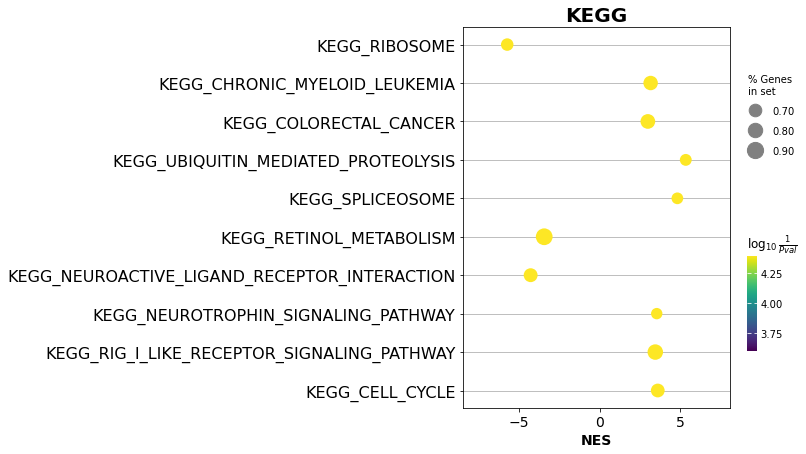

In [37]:
# to save your figure, make sure that ``ofname`` is not None
ax = gseapy.dotplot(pre_res.res2d,
                    column="FDR q-val",
                    title='KEGG',
                    cmap=plt.cm.viridis,
                    size=3,  # adjust dot size
                    figsize=(6, 7), cutoff=0.1, show_ring=False,
                    top_term=10)

In [33]:
# ES signed tests for n2v2r and kegg

# all, tfs , genes, wgcna
sex_and_gender = True
top_k = 5000
num_perms = 2000

# map ensembl to gene name
gencode = pd.read_csv(gencode_fn, index_col=0)

# ensembl to symbol map
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}

n2v2r_gsea_ranked_nodes = n2v2r_ranked_nodes.copy()
n2v2r_gsea_node_scores = n2v2r_avg_distances.copy()

# remove stupid dot if there
n2v2r_gsea_ranked_nodes = [x[0:15] for x in n2v2r_gsea_ranked_nodes]
n2v2r_gsea_node_scores.index = [x[0:15]
                                for x in n2v2r_gsea_node_scores.index.to_list()]

# from ids to names and exluding maybe TFs or Genes for Panda networks

ranked_nodes_symbols = [ens2symbol[x]
                        if "ENSG" in x else x for x in n2v2r_gsea_ranked_nodes]
n2v2r_gsea_node_scores.index = [
    ens2symbol[x] if "ENSG" in x else x for x in n2v2r_gsea_node_scores.index.to_list()]

# remove chrY genes
if sex_and_gender:
    Y_gene_names = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
    ranked_nodes_symbols = [
        x for x in ranked_nodes_symbols if x not in Y_gene_names]


# remove duplicates in case a tf and gene
# have the same name, keeping the first in order
ranked_nodes_symbols = list(dict.fromkeys(ranked_nodes_symbols))

ranked_nodes_n2v2r_for_gsea = []
ranked_node_scores_n2v2r_for_gsea = []

i = 0
for node in reversed(ranked_nodes_symbols):
    # if node in DeDi_genes_name:
    index = DeDi_genes_name.index(node)
    DeDi_value = AbsDeDi[index]
    if DeDi_value >= 0:
        ranked_nodes_n2v2r_for_gsea.insert(0, node)

        ranked_node_scores_n2v2r_for_gsea.insert(
            0, n2v2r_gsea_node_scores[[node]][0])
    else:
        ranked_nodes_n2v2r_for_gsea.append(node)
        ranked_node_scores_n2v2r_for_gsea.append(
            -n2v2r_gsea_node_scores[[node]][0])
    i = i+1
    # else:
    #     continue

n2v2r_data_for_gsea_tests = {
    "genes": ranked_nodes_n2v2r_for_gsea, "score": ranked_node_scores_n2v2r_for_gsea}
n2v2r_data_for_gsea_tests_pd = pd.DataFrame(n2v2r_data_for_gsea_tests)

In [40]:
pre_res_n2v2r = gseapy.prerank(rnk=n2v2r_data_for_gsea_tests_pd,  # or rnk = rnk,
                               gene_sets=kegg_pathway_fn,
                               threads=96,
                               min_size=5,
                               max_size=1000,
                               permutation_num=10000,  # reduce number to speed up testing
                               outdir=None,  # don't write to disk
                               seed=6,
                               verbose=True,  # see what's going on behind the scenes
                               weighted_score_type=0
                               )

2023-03-28 16:00:05,773 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-03-28 16:00:05,774 [INFO] Parsing data files for GSEA.............................
2023-03-28 16:00:05,781 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-03-28 16:00:05,782 [INFO] 0186 gene_sets used for further statistical testing.....
2023-03-28 16:00:05,782 [INFO] Start to run GSEA...Might take a while..................
2023-03-28 16:00:19,439 [INFO] Congratulations. GSEApy runs successfully................



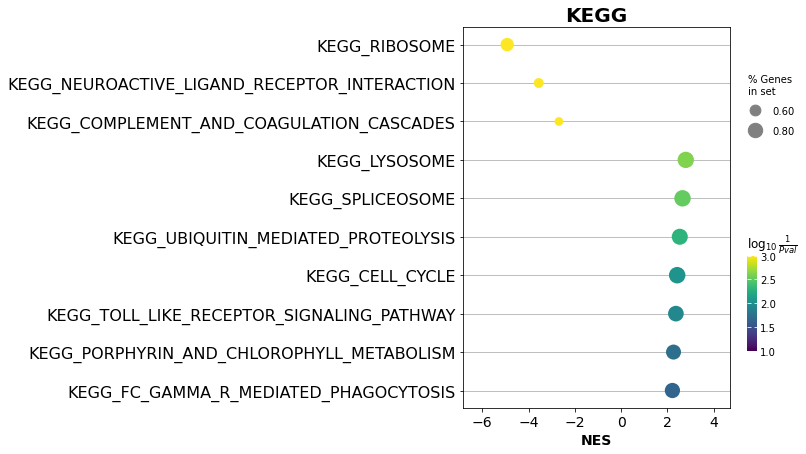

In [41]:
# to save your figure, make sure that ``ofname`` is not None
ax = gseapy.dotplot(pre_res_n2v2r.res2d,
                    column="FDR q-val",
                    title='KEGG',
                    cmap=plt.cm.viridis,
                    size=3,  # adjust dot size
                    figsize=(6, 7), cutoff=0.1, show_ring=False,
                    top_term=10)

In [42]:
# ES unsigned tests for n2v2r and kegg

# all, tfs , genes, wgcna
sex_and_gender = True
top_k = 5000
num_perms = 2000

# map ensembl to gene name
gencode = pd.read_csv(gencode_fn, index_col=0)

# ensembl to symbol map
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}

n2v2r_gsea_ranked_nodes = n2v2r_ranked_nodes.copy()
n2v2r_gsea_node_scores = n2v2r_avg_distances.copy()

# remove stupid dot if there
n2v2r_gsea_ranked_nodes = [x[0:15] for x in n2v2r_gsea_ranked_nodes]
n2v2r_gsea_node_scores.index = [x[0:15]
                                for x in n2v2r_gsea_node_scores.index.to_list()]

# from ids to names and exluding maybe TFs or Genes for Panda networks

ranked_nodes_symbols = [ens2symbol[x]
                        if "ENSG" in x else x for x in n2v2r_gsea_ranked_nodes]
n2v2r_gsea_node_scores.index = [
    ens2symbol[x] if "ENSG" in x else x for x in n2v2r_gsea_node_scores.index.to_list()]

# remove chrY genes
if sex_and_gender:
    Y_gene_names = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
    ranked_nodes_symbols = [
        x for x in ranked_nodes_symbols if x not in Y_gene_names]


# remove duplicates in case a tf and gene
# have the same name, keeping the first in order
ranked_nodes_symbols = list(dict.fromkeys(ranked_nodes_symbols))

ranked_nodes_n2v2r_for_gsea = []
ranked_node_scores_n2v2r_for_gsea = []


i = 0
for node in reversed(ranked_nodes_symbols):
    ranked_nodes_n2v2r_for_gsea.insert(0, node)
    ranked_node_scores_n2v2r_for_gsea.insert(
        0, n2v2r_gsea_node_scores[[node]][0])
    i = i+1

n2v2r_data_for_unsigned_gsea_tests = {
    "genes": ranked_nodes_n2v2r_for_gsea, "score": ranked_node_scores_n2v2r_for_gsea}
n2v2r_data_for_unsigned_gsea_tests_pd = pd.DataFrame(
    n2v2r_data_for_unsigned_gsea_tests)

In [43]:
pre_res_n2v2r = gseapy.prerank(rnk=n2v2r_data_for_unsigned_gsea_tests_pd,  # or rnk = rnk,
                               gene_sets=kegg_pathway_fn,
                               threads=96,
                               min_size=5,
                               max_size=1000,
                               permutation_num=10000,  # reduce number to speed up testing
                               outdir=None,  # don't write to disk
                               seed=6,
                               verbose=True,  # see what's going on behind the scenes
                               weighted_score_type=0
                               )

2023-03-28 16:02:03,468 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-03-28 16:02:03,469 [INFO] Parsing data files for GSEA.............................
2023-03-28 16:02:03,477 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-03-28 16:02:03,478 [INFO] 0186 gene_sets used for further statistical testing.....
2023-03-28 16:02:03,478 [INFO] Start to run GSEA...Might take a while..................
2023-03-28 16:02:17,670 [INFO] Congratulations. GSEApy runs successfully................



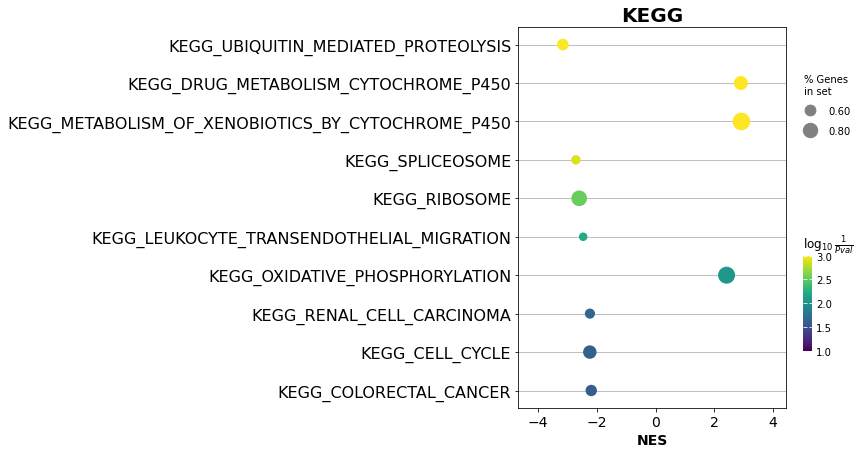

In [44]:
# to save your figure, make sure that ``ofname`` is not None
ax = gseapy.dotplot(pre_res_n2v2r.res2d,
                    column="FDR q-val",
                    title='KEGG',
                    cmap=plt.cm.viridis,
                    size=3,  # adjust dot size1
                    figsize=(6, 7), cutoff=0.1, show_ring=False,
                    top_term=10)

In [45]:
# ES signed tests for dedi and kegg

import gseapy

gencode_fn = '../scripts/gen_v26_mapping.csv'
pathway_fn = '../scripts/c2.cp.kegg.v7.5.1.symbols.gmt'

# map ensembl to gene name
gencode = pd.read_csv(gencode_fn, index_col=0)

# ensembl to symbol map
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}

sex_and_gender = True
top_k = 5000
num_perms = 2000


# PANDA has TFs with symbols and genes with Ens ids
# we remove genes from PANDA rows and TFs from PANDA columns
# should work with Enakshi's networks from edge lists but not sure for others

net_one_adj = grns[0].copy()
net_two_adj = grns[1].copy()


# remove chrY genes
if sex_and_gender:
    chrY_gene_ids = list(gencode.loc[gencode['seqid'] == 'chrY', 'gene_id'])
    chrY_gene_ids = [id[0:15] for id in chrY_gene_ids]
    thisFilter = net_one_adj.filter(chrY_gene_ids)
    net_one_adj.drop(thisFilter, inplace=True, axis=1)
    net_two_adj.drop(thisFilter, inplace=True, axis=1)

# get indegrees
net_one_adj_tar = net_one_adj.sum(axis=0).to_numpy()
net_two_adj_tar = net_two_adj.sum(axis=0).to_numpy()

# get DeDi
AbsDeDi = np.abs(net_one_adj_tar - net_two_adj_tar)
DeDi_genes_id = net_one_adj.columns.to_list()
DeDi_genes_id = [x[0:15] for x in DeDi_genes_id]
DeDi_genes_name = [ens2symbol[x] for x in DeDi_genes_id]
DeDi_data_for_gsea_tests = {"genes": DeDi_genes_name, "score": AbsDeDi}
DeDi_data_for_gsea_tests_pd = pd.DataFrame(DeDi_data_for_gsea_tests)

pre_res = gseapy.prerank(rnk=DeDi_data_for_gsea_tests_pd,  # or rnk = rnk,
                         gene_sets=pathway_fn,
                         threads=96,
                         min_size=5,
                         max_size=1000,
                         permutation_num=10000,  # reduce number to speed up testing
                         outdir=None,  # don't write to disk
                         seed=6,
                         verbose=True,  # see what's going on behind the scenes
                         weighted_score_type=0
                         )

2023-03-28 16:09:06,909 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-03-28 16:09:06,917 [WARNING] Duplicated values found in preranked stats: 0.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-03-28 16:09:06,917 [INFO] Parsing data files for GSEA.............................
2023-03-28 16:09:06,926 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-03-28 16:09:06,926 [INFO] 0186 gene_sets used for further statistical testing.....
2023-03-28 16:09:06,926 [INFO] Start to run GSEA...Might take a while..................
2023-03-28 16:09:21,028 [INFO] Congratulations. GSEApy runs successfully................



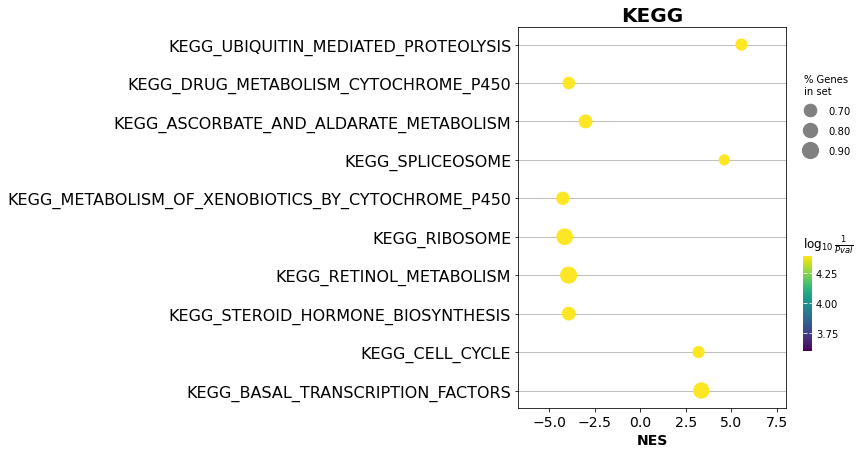

In [47]:
# to save your figure, make sure that ``ofname`` is not None
ax = gseapy.dotplot(pre_res.res2d,
                    column="FDR q-val",
                    title='KEGG',
                    cmap=plt.cm.viridis,
                    size=3,  # adjust dot size
                    figsize=(6, 7), cutoff=0.1, show_ring=False,
                    top_term=10)